In [7]:
!pip install -q evaluate torchinfo bitsandbytes peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.0 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
from datasets import Dataset
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from torchinfo import summary
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Datasets, Tokenizer, and Model

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_test.csv')

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [9]:
# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def preprocess(batch):
    # Ensure all entries are strings and handle missing values
    review_texts = [str(x) for x in batch['text_cleaned']]
    encoded = tokenizer(
        review_texts,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="pt"
    )

    # Return input features and the label
    return {
        'input_ids': encoded['input_ids'].tolist(),
        'token_type_ids': encoded['token_type_ids'].tolist(),
        'attention_mask': encoded['attention_mask'].tolist(),
        'labels': batch['hatespeech'] # Keep the 'hatespeech' column as labels
    }


train_dataset = train_dataset.map(preprocess, batched=True)
val_dataset = val_dataset.map(preprocess, batched=True)

# Identify columns to remove (all except the new ones)
original_columns = train_df.columns.tolist()
columns_to_keep = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
columns_to_remove = [col for col in original_columns if col not in columns_to_keep]

# Remove original columns from the datasets
train_dataset = train_dataset.remove_columns(columns_to_remove)
val_dataset = val_dataset.remove_columns(columns_to_remove)

Map:   0%|          | 0/26852 [00:00<?, ? examples/s]

Map:   0%|          | 0/3360 [00:00<?, ? examples/s]

In [11]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 26852
})

In [12]:
# Show a sample input and output

text = train_df.iloc[5000]['text_cleaned']
encoded_input = tokenizer(text, return_tensors='pt')

# Move input tensors to the same device as the model
device = model.device
encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

output = model(**encoded_input)

print(text)
print(encoded_input)
print(output)

sjw et féministe twitter un sale combo
{'input_ids': tensor([[  101,   187, 10418, 10874, 10131, 92415, 37249, 11157,   188, 56082,
         10877, 10119, 15488, 10212, 11790,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0707, -0.1528]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


## Model Structure

In [13]:
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [14]:
# Freeze all of the pre-trained BERT layers to make the fine tuning go much faster.
# Then later we'll try unfreezing some or all layers and see what works better.
# We need to keep the final classification layer unfrozen no matter what,
# because that's a new layer that hasn't been trained at all yet, and needs to be trained for our task.


for name, param in model.named_parameters():
    if name.split(".")[0] == "bert":
        param.requires_grad = False

In [15]:

# confirm all pre-trained layers are frozen
summary(model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   (91,812,096)
│    │    └─Embedding: 3-2                                   (393,216)
│    │    └─Embedding: 3-3                                   (1,536)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                         

## Model Training

In [16]:
batch_size = 16
num_epochs = 1

training_args = TrainingArguments(
    output_dir="model_checkpoints",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to='none'
)

In [18]:
import evaluate
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Load the accuracy metric
accuracy_metric = evaluate.load('accuracy')

def compute_metrics(p):
    predictions, labels = p
    # For single-label classification, use argmax to get predicted labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=predicted_labels, references=labels)
    precision = precision_score(labels, predicted_labels, zero_division=0)
    recall = recall_score(labels, predicted_labels, zero_division=0)
    f1 = f1_score(labels, predicted_labels, zero_division=0)

    # For AUC, we need the probabilities of the positive class (assuming binary classification)
    # If predictions are logits, apply softmax or sigmoid to get probabilities
    if predictions.shape[-1] == 2: # Check if it's a binary classification output
        probabilities = torch.softmax(torch.tensor(predictions), dim=1)[:, 1].numpy()
        auc = roc_auc_score(labels, probabilities)
    else: # Handle cases that are not binary classification
        auc = None # Or compute a different type of AUC if applicable

    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': auc
    }

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.640900,0.636254,0.654167,0.631854,0.906367,0.744615,0.794801


TrainOutput(global_step=1679, training_loss=0.6546019599010292, metrics={'train_runtime': 919.9273, 'train_samples_per_second': 29.189, 'train_steps_per_second': 1.825, 'total_flos': 7065058058526720.0, 'train_loss': 0.6546019599010292, 'epoch': 1.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.6362536549568176,
 'eval_accuracy': 0.6541666666666667,
 'eval_precision': 0.6318537859007833,
 'eval_recall': 0.9063670411985019,
 'eval_f1': 0.7446153846153846,
 'eval_roc_auc': 0.794801087602842,
 'eval_runtime': 95.7231,
 'eval_samples_per_second': 35.101,
 'eval_steps_per_second': 2.194,
 'epoch': 1.0}

In [31]:
# Get a sample from the validation dataset
sample_index = 2500
val_sample = val_dataset[sample_index]

# Prepare the input for the model
inputs = {
    'input_ids': torch.tensor([val_sample['input_ids']]),
    'attention_mask': torch.tensor([val_sample['attention_mask']]),
    'token_type_ids': torch.tensor([val_sample['token_type_ids']]) # Added token_type_ids
}

# Move input tensors to the same device as the model
device = model.device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get the model prediction
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(**inputs)

# Access the correct logits from the dictionary output and calculate probabilities
# hatespeech_logits = outputs['hatespeech_logits'] # Removed incorrect key
logits = outputs['logits'] # Accessed logits using the correct key
hatespeech_probabilities = torch.softmax(logits, dim=1)
predicted_hatespeech_label = torch.argmax(logits, dim=1).item()

print(f"Text: {tokenizer.decode(val_sample['input_ids'])}")
print(f"True Hatespeech Label: {val_sample['labels']}") # Corrected label access
print(f"Predicted Hatespeech Label: {predicted_hatespeech_label}")
print(f"Hatespeech Probabilities: {hatespeech_probabilities.tolist()}")

Text: [CLS] oh look another jumped feminazi looking sexism there. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [24]:
true_hatespeech_labels = []
predicted_hatespeech_labels = []

device = model.device

for val_sample in val_dataset:
    inputs = {
        'input_ids': torch.tensor([val_sample['input_ids']]).to(device),
        'attention_mask': torch.tensor([val_sample['attention_mask']]).to(device)
    }

    with torch.no_grad():
        outputs = model(**inputs)

    hatespeech_logits = outputs['logits']
    predicted_hatespeech_label = torch.argmax(hatespeech_logits, dim=1).item()

    true_hatespeech_labels.append(val_sample['labels'])
    predicted_hatespeech_labels.append(predicted_hatespeech_label)

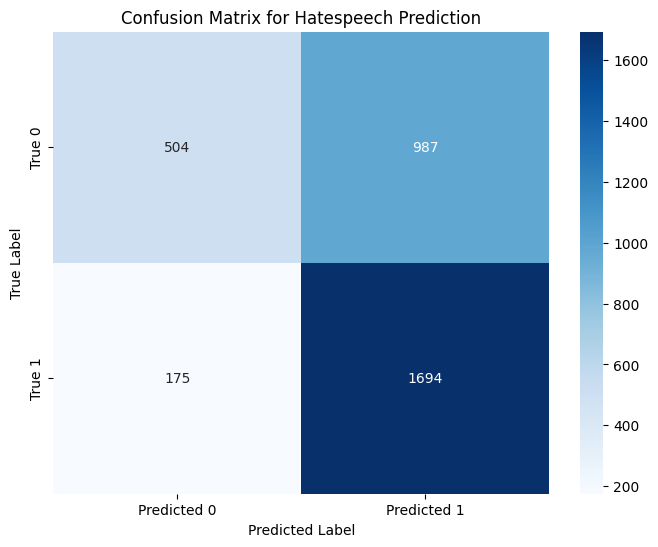

In [27]:
cm = confusion_matrix(true_hatespeech_labels, predicted_hatespeech_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Hatespeech Prediction')
plt.show()

## Multi-Label Prediction

In [32]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

example = train_dataset[0]
example

{'text_cleaned': 'رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرضةً عن الصُلح . . ! @ مدينة الحصن',
 'language': 'arabic',
 'directness_label': 2,
 'target_label': 2,
 'group_label': 12,
 'hatespeech': 0,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 0,
 'sentiment_fear': 0,
 'sentiment_indifference': 0,
 'sentiment_normal': 1,
 'sentiment_sadness': 0,
 'sentiment_shock': 0}

In [33]:
from datasets import DatasetDict

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock'],
        num_rows: 26852
    })
    validation: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock'],
        num_rows: 3360
    })
    test: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock'],
        num_rows: 

In [39]:
example = dataset['train'][13000]
example

{'text_cleaned': "Its crazy how half us 90's babies got old souls and the other half retarded af.",
 'language': 'english',
 'directness_label': 1,
 'target_label': 1,
 'group_label': 16,
 'hatespeech': 1,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 1,
 'sentiment_fear': 0,
 'sentiment_indifference': 1,
 'sentiment_normal': 0,
 'sentiment_sadness': 0,
 'sentiment_shock': 0}

In [62]:
# Original binary labels
binary_label_columns = [
    'hatespeech',
    'sentiment_indifference',
    'sentiment_disgust',
    'sentiment_sadness',
    'sentiment_anger',
    'sentiment_shock',
    'sentiment_normal',
    'sentiment_confusion',
    'sentiment_fear'
]

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

# Create names for one-hot encoded binary labels
directness_binary_labels = [f'directness_label_{val}' for val in directness_values]
target_binary_labels = [f'target_label_{val}' for val in target_values]
group_binary_labels = [f'group_label_{val}' for val in group_values]

# Combine all binary label names
all_binary_labels = binary_label_columns + directness_binary_labels + target_binary_labels + group_binary_labels

# Update id2label and label2id
id2label = {idx:label for idx, label in enumerate(all_binary_labels)}
label2id = {label:idx for idx, label in enumerate(all_binary_labels)}

# The total number of binary labels
num_binary_labels = len(all_binary_labels)

print(f"Total number of binary labels: {num_binary_labels}")
print(f"All binary labels: {all_binary_labels}")

Total number of binary labels: 36
All binary labels: ['hatespeech', 'sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger', 'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear', 'directness_label_0', 'directness_label_1', 'directness_label_2', 'target_label_0', 'target_label_1', 'target_label_2', 'target_label_3', 'target_label_4', 'target_label_5', 'target_label_6', 'group_label_0', 'group_label_1', 'group_label_2', 'group_label_3', 'group_label_4', 'group_label_5', 'group_label_6', 'group_label_7', 'group_label_8', 'group_label_9', 'group_label_10', 'group_label_11', 'group_label_12', 'group_label_13', 'group_label_14', 'group_label_15', 'group_label_16']


In [87]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-multilingual-cased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(all_binary_labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
import torch
import numpy as np

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

def preprocess_multioutput_data(examples):
  # take a batch of texts
  text = [str(x) for x in examples["text_cleaned"]]
  # encode them, returning PyTorch tensors directly
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=150, return_tensors="pt")

  # Create list of binary label tensors
  binary_labels_list = [
      torch.tensor(examples["hatespeech"]),
      torch.tensor(examples["sentiment_anger"]),
      torch.tensor(examples["sentiment_confusion"]),
      torch.tensor(examples["sentiment_disgust"]),
      torch.tensor(examples["sentiment_fear"]),
      torch.tensor(examples["sentiment_indifference"]),
      torch.tensor(examples["sentiment_normal"]),
      torch.tensor(examples["sentiment_sadness"]),
      torch.tensor(examples["sentiment_shock"])
  ]

  # Perform one-hot encoding for multiclass labels and add to the list
  for i, val in enumerate(directness_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["directness_label"]]))

  for i, val in enumerate(target_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["target_label"]]))

  for i, val in enumerate(group_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["group_label"]]))


  # Stack all binary label tensors along dimension 1
  labels_tensor = torch.stack(binary_labels_list, dim=1).float()

  # Add the stacked labels tensor to the encoding dictionary
  encoding['labels'] = labels_tensor

  return encoding

In [89]:


# Apply the preprocessing function with batching
encoded_dataset = dataset.map(preprocess_multioutput_data, batched=True, remove_columns=dataset['train'].column_names)


Map:   0%|          | 0/26852 [00:00<?, ? examples/s]

Map:   0%|          | 0/3360 [00:00<?, ? examples/s]

Map:   0%|          | 0/3354 [00:00<?, ? examples/s]

In [90]:
example = encoded_dataset['train'][13000]
print(example.keys())

print(tokenizer.decode(example['input_ids']))

print(example)

dict_keys(['input_ids', 'attention_mask', 'labels'])
[CLS] Its crazy how half us 90 ' s babies got old souls and the other half retarded af. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
{'input_ids': [101, 14864, 171, 29948, 10157, 14796, 13877, 19626, 10919, 112, 187, 15688, 68275, 19556, 12898, 330

In [91]:
for name, param in model.named_parameters():
    print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

In [93]:
# Freeze all of the pre-trained BERT layers to make the fine tuning go much faster.
# Then later we'll try unfreezing some or all layers and see what works better.
# We need to keep the final classification layer unfrozen no matter what,
# because that's a new layer that hasn't been trained at all yet, and needs to be trained for our task.


for name, param in model.distilbert.named_parameters():
    param.requires_grad = False

In [94]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (91,812,096)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           27,684
├─Dropout: 1-4                                          --
Total params: 135,352,356
Trainable params: 618,276
Non-trainable params: 134,734,080

In [95]:
from transformers import TrainingArguments, Trainer

batch_size = 64
metric_name = "f1"

args = TrainingArguments(
    f"distilbert-base-multilingual-cased",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [96]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from transformers import EvalPrediction
import torch
import numpy as np # Import numpy

def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels.astype(int) # Ensure labels are integers
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    recall = recall_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'precision': precision,
               'recall': recall}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions

    # Ensure labels are a 2D numpy array of integers
    labels_np = np.array(p.label_ids)
    if labels_np.ndim == 1:
        # This might happen if the batch size is 1, reshape to (1, num_labels)
        labels_np = labels_np.reshape(1, -1)
    elif labels_np.ndim > 2:
        # Handle cases where labels might have extra dimensions unexpectedly
        # This might require more specific reshaping based on the actual structure
        # For now, let's assume the expected shape is (batch_size, num_labels)
        # and try to flatten and reshape if necessary.
        # A safer approach might be to raise an error or log a warning here.
        print(f"Warning: Unexpected label dimension: {labels_np.ndim}")
        # Attempt to flatten and reshape - adjust if your data structure is different
        labels_np = labels_np.reshape(labels_np.shape[0], -1)


    result = multi_label_metrics(
        predictions=preds,
        labels=labels_np)
    return result

In [97]:
#forward pass
# # Check the type of the data after setting the format
# print(f"Type of input_ids[0]: {encoded_dataset['train']['input_ids'][0].type()}")
# print(f"Type of labels[0]: {encoded_dataset['train'][0]['hatespeech_labels'].type()}")

# Also print a sample example to see the structure
print("Sample example after setting format:")
print(encoded_dataset['train'][0])

# Manually get a sample and prepare input for the model
sample = encoded_dataset['train'][0]

# Convert lists to PyTorch tensors before unsqueezing
input_ids_tensor = torch.tensor(sample['input_ids']).unsqueeze(0)
attention_mask_tensor = torch.tensor(sample['attention_mask']).unsqueeze(0)
labels_tensor = torch.tensor(sample['labels']).unsqueeze(0)

# Move tensors to the same device as the model
device = model.device
input_ids_tensor = input_ids_tensor.to(device)
attention_mask_tensor = attention_mask_tensor.to(device)
labels_tensor = labels_tensor.to(device)


outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor, labels=labels_tensor)
outputs

Sample example after setting format:
{'input_ids': [101, 773, 40381, 108039, 785, 40381, 35487, 15285, 59901, 111171, 28997, 38901, 10673, 22543, 752, 85648, 10429, 12441, 774, 85589, 788, 40381, 39404, 10382, 16275, 11749, 59901, 15470, 40381, 87536, 119, 119, 106, 137, 17065, 59901, 12616, 15470, 10582, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

SequenceClassifierOutput(loss=tensor(0.6952, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.1008, -0.1169,  0.0033, -0.0380, -0.1773, -0.2160, -0.0239,  0.0606,
         -0.0159,  0.0412,  0.0932,  0.0466, -0.0361,  0.2418,  0.0246, -0.1771,
          0.1358,  0.1042, -0.0726,  0.0167, -0.2740,  0.0692,  0.0557,  0.0356,
         -0.0672,  0.1161, -0.0829,  0.1019, -0.1479,  0.0900,  0.2284,  0.1757,
          0.0536,  0.1185, -0.0105,  0.0139]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [98]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-98-3132099784.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [99]:
print(encoded_dataset['train']['labels'][13000])

[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [100]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,No log,0.295265,0.295297,0.586486,0.036607,0.671964,0.189227
2,0.352100,0.268141,0.489775,0.673172,0.222917,0.714876,0.372486
3,0.269800,0.261641,0.516143,0.688799,0.238095,0.702091,0.408066
4,0.257400,0.259604,0.521125,0.692121,0.236310,0.697287,0.416022
5,0.252500,0.258472,0.527448,0.695533,0.246429,0.700888,0.422818


TrainOutput(global_step=2100, training_loss=0.28164148603166855, metrics={'train_runtime': 683.8389, 'train_samples_per_second': 196.333, 'train_steps_per_second': 3.071, 'total_flos': 5213629914696000.0, 'train_loss': 0.28164148603166855, 'epoch': 5.0})

In [101]:
trainer.evaluate()

{'eval_loss': 0.25847238302230835,
 'eval_f1': 0.5274475343740308,
 'eval_roc_auc': 0.6955328918886691,
 'eval_accuracy': 0.24642857142857144,
 'eval_precision': 0.7008883597399029,
 'eval_recall': 0.42281767955801103,
 'eval_runtime': 13.3534,
 'eval_samples_per_second': 251.621,
 'eval_steps_per_second': 3.969,
 'epoch': 5.0}

In [102]:
text = "I'm happy I can finally train a model for multi-label classification"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [103]:
logits = outputs.logits
logits.shape

torch.Size([1, 36])

In [104]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print("Predicted labels (names):", predicted_labels)
print("Predicted labels (binary values):", predictions)

Predicted labels (names): ['sentiment_normal', 'directness_label_2', 'target_label_2', 'group_label_12']
Predicted labels (binary values): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [105]:
true_labels = []
predicted_logits = []

device = trainer.model.device

for sample in encoded_dataset["validation"]:
    inputs = {
        'input_ids': torch.tensor([sample['input_ids']]).to(device),
        'attention_mask': torch.tensor([sample['attention_mask']]).to(device)
    }

    with torch.no_grad():
        outputs = trainer.model(**inputs)

    # Append the true labels and predicted logits
    true_labels.append(sample['labels'])
    predicted_logits.append(outputs.logits.squeeze().cpu().numpy())


In [106]:
# Convert lists to numpy arrays
true_labels_np = np.array(true_labels)
predicted_logits_np = np.array(predicted_logits)

# Define indices for each label group based on all_binary_labels
hatespeech_idx = all_binary_labels.index('hatespeech')
sentiment_indices = [all_binary_labels.index(label) for label in binary_label_columns if 'sentiment' in label]
directness_indices = [all_binary_labels.index(label) for label in directness_binary_labels]
target_indices = [all_binary_labels.index(label) for label in target_binary_labels]
group_indices = [all_binary_labels.index(label) for label in group_binary_labels]


# Split true labels and predicted logits
true_hatespeech = true_labels_np[:, hatespeech_idx]
predicted_hatespeech_logits = predicted_logits_np[:, hatespeech_idx]

true_sentiment_labels = true_labels_np[:, sentiment_indices]
predicted_sentiment_logits = predicted_logits_np[:, sentiment_indices]

true_directness_labels = true_labels_np[:, directness_indices]
predicted_directness_logits = predicted_logits_np[:, directness_indices]

true_target_labels = true_labels_np[:, target_indices]
predicted_target_logits = predicted_logits_np[:, target_indices]

true_group_labels = true_labels_np[:, group_indices]
predicted_group_logits = predicted_logits_np[:, group_indices]

print("True Hatespeech Labels shape:", true_hatespeech.shape)
print("Predicted Hatespeech Logits shape:", predicted_hatespeech_logits.shape)
print("True Sentiment Labels shape:", true_sentiment_labels.shape)
print("Predicted Sentiment Logits shape:", predicted_sentiment_logits.shape)
print("True Directness Labels shape:", true_directness_labels.shape)
print("Predicted Directness Logits shape:", predicted_directness_logits.shape)
print("True Target Labels shape:", true_target_labels.shape)
print("Predicted Target Logits shape:", predicted_target_logits.shape)
print("True Group Labels shape:", true_group_labels.shape)
print("Predicted Group Logits shape:", predicted_group_logits.shape)

True Hatespeech Labels shape: (3360,)
Predicted Hatespeech Logits shape: (3360,)
True Sentiment Labels shape: (3360, 8)
Predicted Sentiment Logits shape: (3360, 8)
True Directness Labels shape: (3360, 3)
Predicted Directness Logits shape: (3360, 3)
True Target Labels shape: (3360, 7)
Predicted Target Logits shape: (3360, 7)
True Group Labels shape: (3360, 17)
Predicted Group Logits shape: (3360, 17)


In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics_and_confusion_matrix(true_labels, predicted_logits, threshold=0.5, is_multilabel=True):
    """
    Calculates classification metrics and confusion matrix.

    Args:
        true_labels (np.ndarray): True labels (binary).
        predicted_logits (np.ndarray): Predicted logits from the model.
        threshold (float): Threshold to convert probabilities to binary predictions.
        is_multilabel (bool): Whether the task is multi-label classification.

    Returns:
        dict: Dictionary containing accuracy, precision, recall, and F1 score.
        np.ndarray: Confusion matrix.
    """
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predicted_logits)).numpy()

    if is_multilabel:
        # For multi-label, apply threshold to each label independently
        predicted_labels = (probs >= threshold).astype(int)
    else:
        # For binary (hatespeech), apply threshold to the single output
        predicted_labels = (probs >= threshold).astype(int)


    # Calculate metrics
    accuracy = accuracy_score(true_labels.flatten(), predicted_labels.flatten())
    precision = precision_score(true_labels.flatten(), predicted_labels.flatten(), average='micro', zero_division=0)
    recall = recall_score(true_labels.flatten(), predicted_labels.flatten(), average='micro', zero_division=0)
    f1 = f1_score(true_labels.flatten(), predicted_labels.flatten(), average='micro', zero_division=0)

    # Calculate confusion matrix - Note: For multi-label, CM is often calculated per label or overall
    # A simple overall CM for multilabel can be misleading. We'll calculate it based on flattened arrays
    # which treats each label prediction as a separate instance.
    cm = confusion_matrix(true_labels.flatten(), predicted_labels.flatten())


    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    return metrics, cm

# Calculate metrics and confusion matrices for each group

# Hatespeech (Binary Classification)
hatespeech_metrics, hatespeech_cm = calculate_metrics_and_confusion_matrix(
    true_hatespeech, predicted_hatespeech_logits, is_multilabel=False
)
print("Hatespeech Metrics:", hatespeech_metrics)
print("Hatespeech Confusion Matrix:\n", hatespeech_cm)


# Sentiment (Multi-label Classification)
sentiment_metrics, sentiment_cm = calculate_metrics_and_confusion_matrix(
    true_sentiment_labels, predicted_sentiment_logits, is_multilabel=True
)
print("\nSentiment Metrics (Micro Avg):", sentiment_metrics)
print("Sentiment Confusion Matrix (Flattened):\n", sentiment_cm)


# Directness (Multi-label Classification - treated as binary for each category)
directness_metrics, directness_cm = calculate_metrics_and_confusion_matrix(
    true_directness_labels, predicted_directness_logits, is_multilabel=True
)
print("\nDirectness Metrics (Micro Avg):", directness_metrics)
print("Directness Confusion Matrix (Flattened):\n", directness_cm)

# Target (Multi-label Classification - treated as binary for each category)
target_metrics, target_cm = calculate_metrics_and_confusion_matrix(
    true_target_labels, predicted_target_logits, is_multilabel=True
)
print("\nTarget Metrics (Micro Avg):", target_metrics)
print("Target Confusion Matrix (Flattened):\n", target_cm)

# Group (Multi-label Classification - treated as binary for each category)
group_metrics, group_cm = calculate_metrics_and_confusion_matrix(
    true_group_labels, predicted_group_logits, is_multilabel=True
)
print("\nGroup Metrics (Micro Avg):", group_metrics)
print("Group Confusion Matrix (Flattened):\n", group_cm)

Hatespeech Metrics: {'accuracy': 0.7288690476190476, 'precision': 0.7288690476190476, 'recall': 0.7288690476190476, 'f1': 0.7288690476190476}
Hatespeech Confusion Matrix:
 [[ 848  643]
 [ 268 1601]]

Sentiment Metrics (Micro Avg): {'accuracy': 0.7962053571428571, 'precision': 0.7962053571428571, 'recall': 0.7962053571428571, 'f1': 0.7962053571428571}
Sentiment Confusion Matrix (Flattened):
 [[19171  1558]
 [ 3920  2231]]

Directness Metrics (Micro Avg): {'accuracy': 0.8205357142857143, 'precision': 0.8205357142857143, 'recall': 0.8205357142857143, 'f1': 0.8205357142857143}
Directness Confusion Matrix (Flattened):
 [[6317  403]
 [1406 1954]]

Target Metrics (Micro Avg): {'accuracy': 0.8826955782312925, 'precision': 0.8826955782312925, 'recall': 0.8826955782312925, 'f1': 0.8826955782312925}
Target Confusion Matrix (Flattened):
 [[19778   382]
 [ 2377   983]]

Group Metrics (Micro Avg): {'accuracy': 0.951750700280112, 'precision': 0.951750700280112, 'recall': 0.951750700280112, 'f1': 0.95

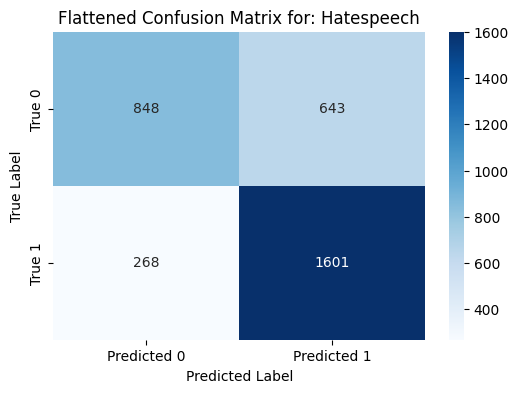

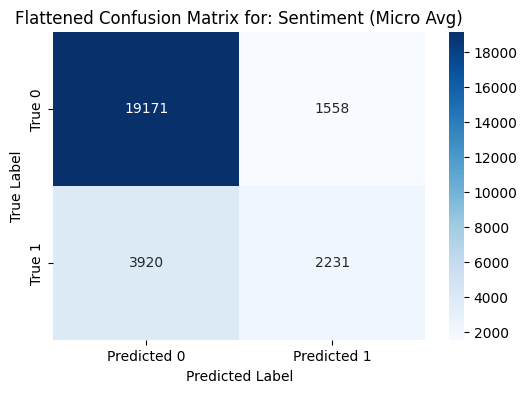

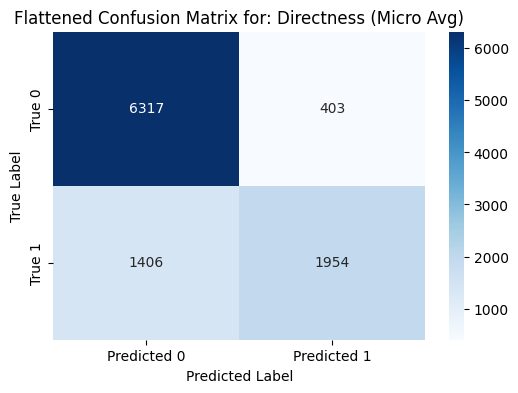

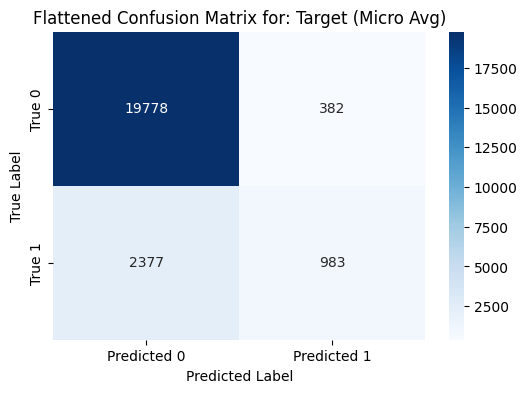

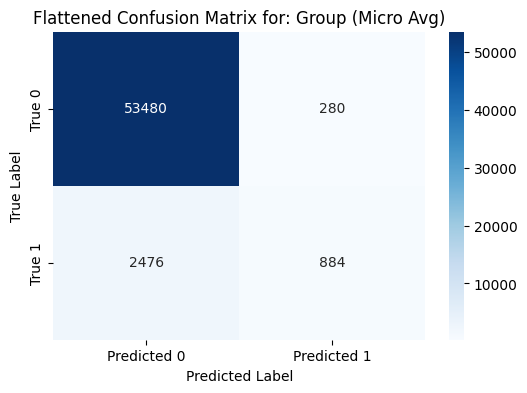

In [110]:
# Visualize Flattened Confusion Matrices for each group

# Hatespeech Flattened Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(hatespeech_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Hatespeech')
plt.show()

# Sentiment Flattened Confusion Matrix (Micro Avg across labels)
# Note: This matrix is based on the flattened true and predicted labels across all sentiment types.
plt.figure(figsize=(6, 4))
sns.heatmap(sentiment_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Sentiment (Micro Avg)')
plt.show()

# Directness Flattened Confusion Matrix (Micro Avg across categories)
# Note: This matrix is based on the flattened true and predicted labels across all directness categories.
plt.figure(figsize=(6, 4))
sns.heatmap(directness_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Directness (Micro Avg)')
plt.show()


# Target Flattened Confusion Matrix (Micro Avg across categories)
# Note: This matrix is based on the flattened true and predicted labels across all target categories.
plt.figure(figsize=(6, 4))
sns.heatmap(target_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Target (Micro Avg)')
plt.show()

# Group Flattened Confusion Matrix (Micro Avg across categories)
# Note: This matrix is based on the flattened true and predicted labels across all group categories.
plt.figure(figsize=(6, 4))
sns.heatmap(group_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Group (Micro Avg)')
plt.show()

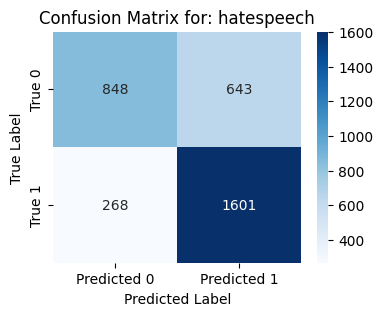

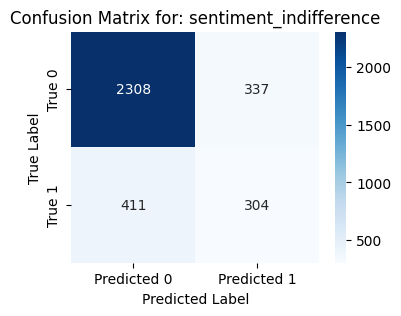

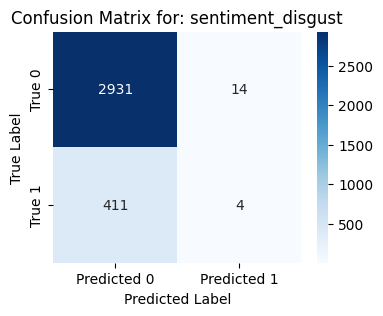

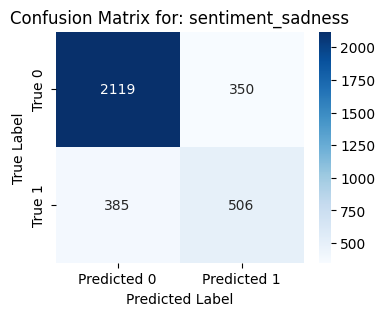

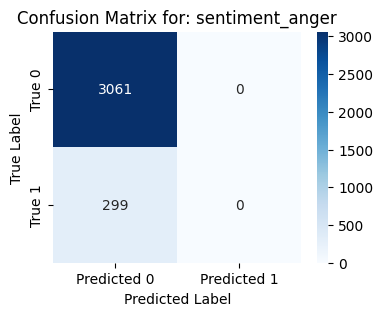

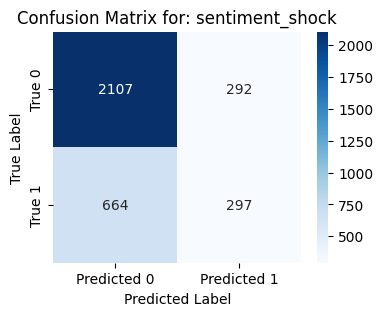

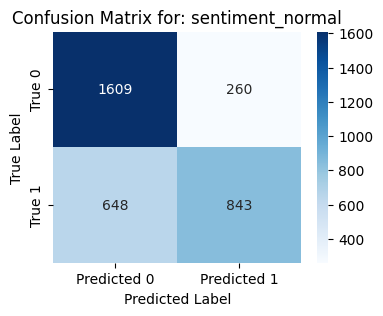

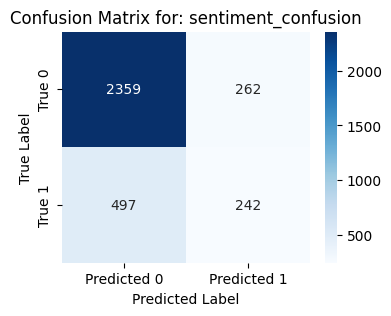

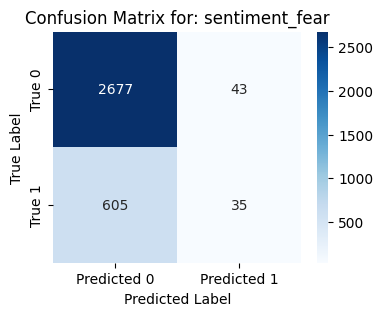

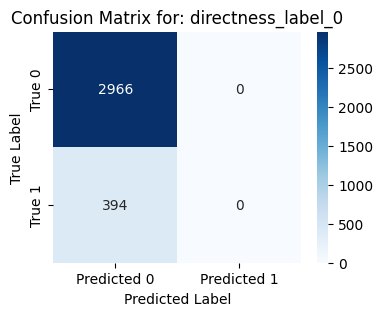

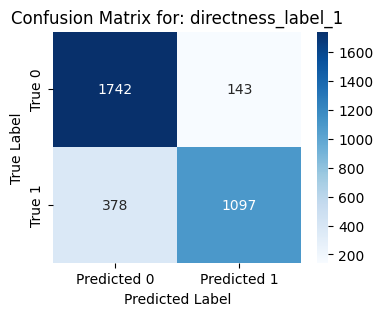

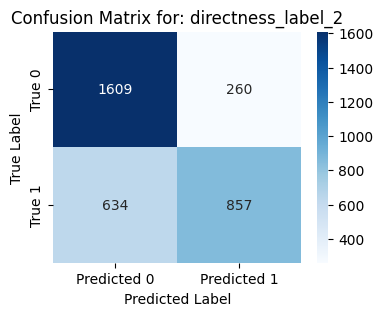

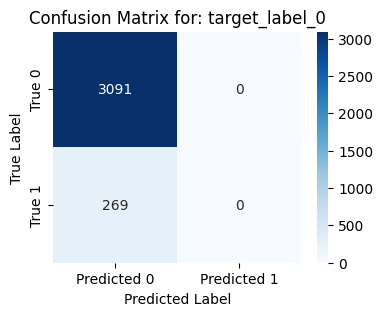

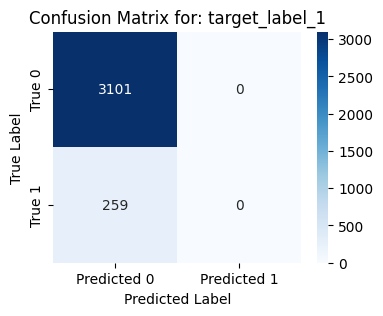

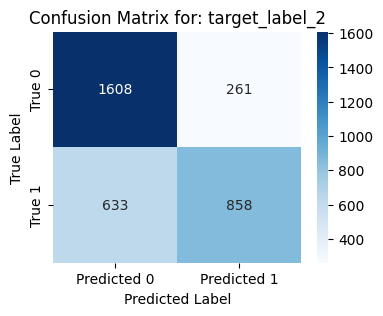

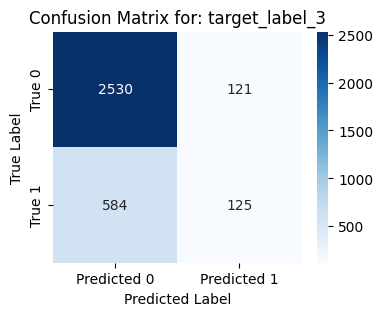

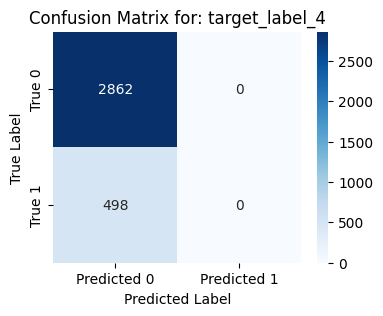

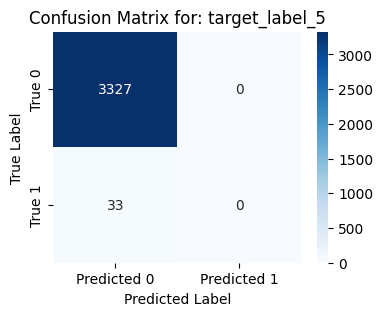

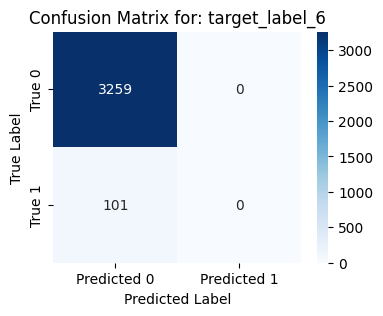

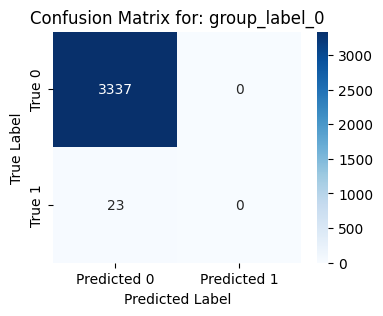

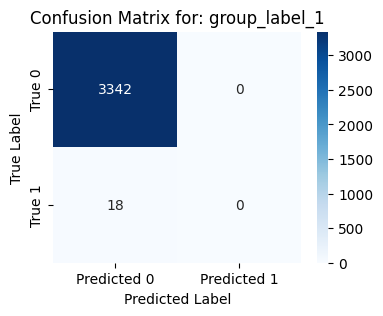

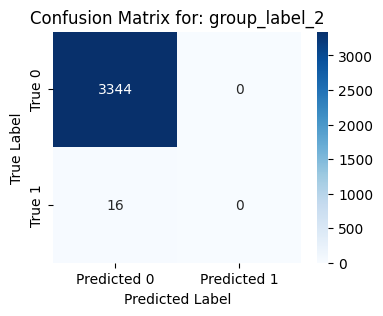

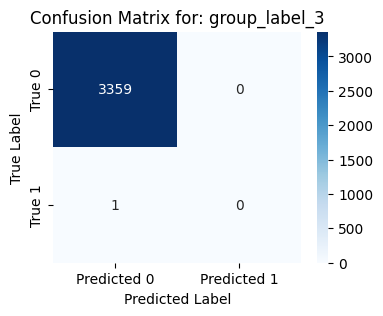

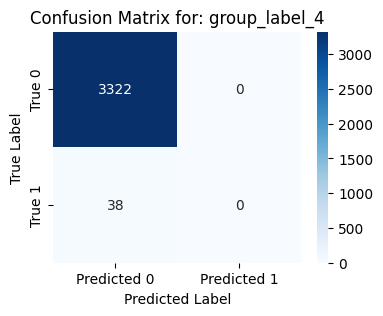

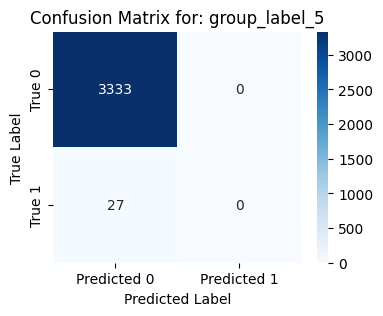

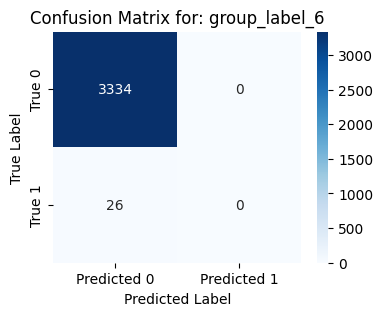

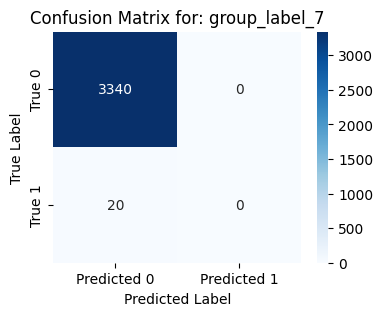

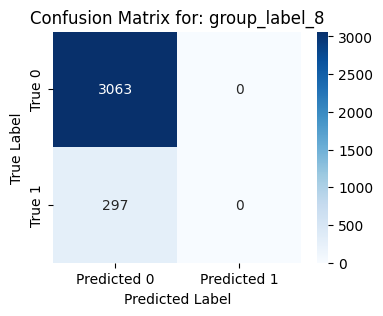

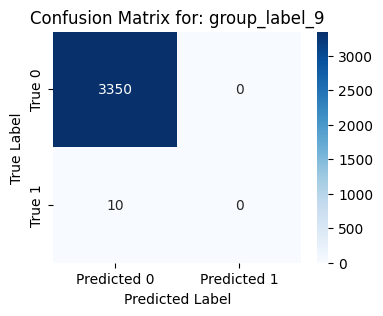

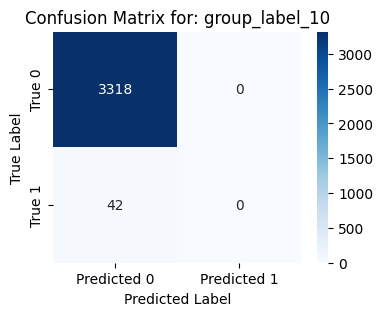

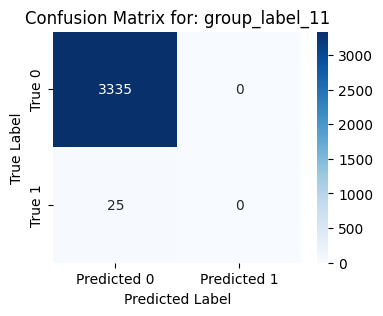

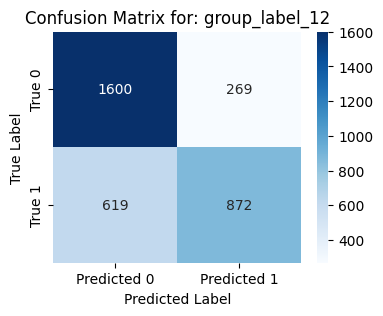

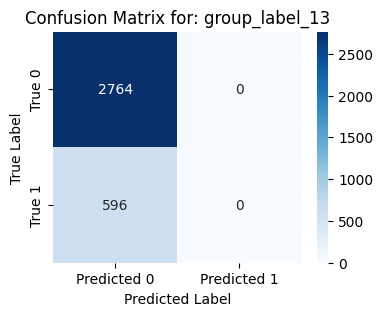

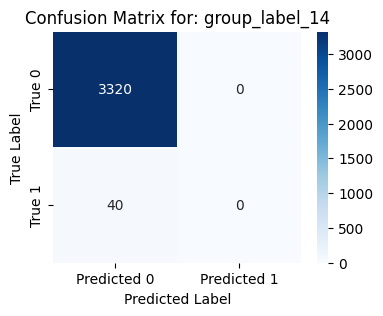

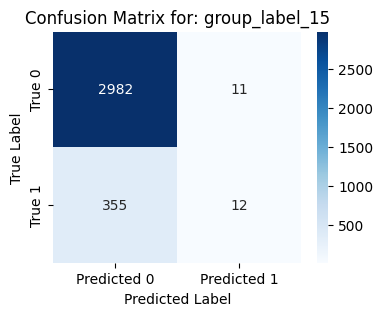

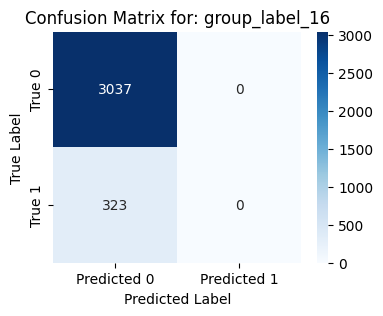

In [111]:
# Visualize Confusion Matrices for each individual binary label

# Apply sigmoid to get probabilities
sigmoid = torch.nn.Sigmoid()
predicted_probs_np = sigmoid(torch.Tensor(predicted_logits_np)).numpy()

# Apply threshold to get binary predictions for each label
predicted_binary_labels_np = (predicted_probs_np >= 0.5).astype(int)


# Iterate through each binary label and plot its confusion matrix
for i, label_name in id2label.items():
    true_binary = true_labels_np[:, i]
    predicted_binary = predicted_binary_labels_np[:, i]

    # Calculate confusion matrix for the current binary label
    cm = confusion_matrix(true_binary, predicted_binary)

    # Plot the confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for: {label_name}')
    plt.show()